This file protoypes script to send to slurm. 

Iterates through each data folder and only picks out files with "flair"


To test:

create folder "../lib"

create folder "../results"

Move a few Brats data direcotries into lib



# script to send to slurm

../lib/BraTS20_Training_232
BraTS20_Training_232


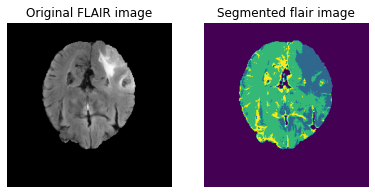

../lib/BraTS20_Training_230
BraTS20_Training_230


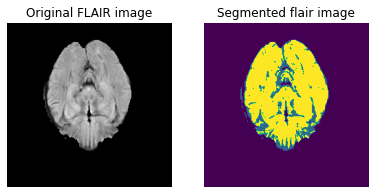

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from dipy.io.image import load_nifti
import pandas as pd
import sklearn.cluster
import pathlib


'''
Path to directory containing Brats data (probably LGG or HGG)
'''

#path_to_lib = "../../lib/MICCAI_BraTS2020_TrainingData"
path_to_lib = "../lib"

'''
path to results
'''
path_to_results = "../results/"

'''
Function for finding mean and varieance of each cluster
'''
def calc_mean_var(flair_2D, flair_kmeans, clusters):
    kmeans_arr=np.zeros((clusters, 2))
    for i in range(0, clusters):
        section=flair_2D[flair_kmeans==i]
        kmeans_arr[i]=np.array([np.mean(section), np.std(section)])
    return kmeans_arr

'''
total clusters in FLAIR image (background, WM , GM, tumor)
'''
clusters = 4

'''
total size of data
'''
flat_length=240*240*155

'''
holds names of MRI data identifiers in the order they were accessed
'''
data_order_ref = []

'''
holds cluster means and variances
'''
mean_var_list = []


'''
Iterate through each MRI folder, extract FLAIR image, and convert to kmeans
'''
for folder_path in pathlib.Path(path_to_lib).iterdir():
    print(str(folder_path))
    data_id = folder_path.parts[len(folder_path.parts)-1]
    for path in pathlib.Path(folder_path).iterdir():
        #check if file is FLAIR
        if path.is_file() and ("flair" in str(path)):
            
            print(data_id)
            data_flair, affine, im = load_nifti(path, return_img=True)
            
            #reshape
            flair_2D = data_flair.reshape(flat_length, 1) #kmeans needs 2d (vertical) matrix where each row is a datapoint
            flair_kmeans = sklearn.cluster.KMeans(n_clusters=clusters, random_state=0).fit_predict(flair_2D)
            
            
            flair_kmeans_brain = flair_kmeans.reshape(240, 240, 155)
            plt.figure(figsize=(10,5))

            plt.subplot(1,3,1).set_axis_off()
            plt.title("Original FLAIR image")
            plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

            plt.subplot(1,3,2).set_axis_off()
            plt.title("Segmented flair image")
            plt.imshow(flair_kmeans_brain[:,:,60].T,  origin='lower')
            
            #write data output
            np.save(path_to_results+data_id+".npy", flair_kmeans_brain, allow_pickle=True, fix_imports=True)
            mean_var_list.append(calc_mean_var(flair_2D, flair_kmeans, clusters))
            data_order_ref.append(data_id)

            plt.show()
dct = {"names": np.asarray(data_order_ref),"data": np.asarray(mean_var_list)}
np.savez(path_to_results+"/aggregate.npz", **dct)

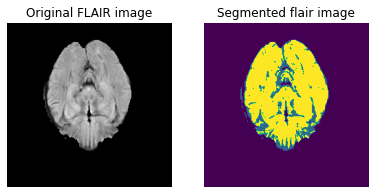

In [3]:
kmeans_brain = np.load("../results/BraTS20_Training_230.npy")
plt.figure(figsize=(10,5))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(kmeans_brain[:,:,60].T,  origin='lower')



In [4]:
res = np.load("../results/aggregate.npz", allow_pickle=True)
dict(res)

{'names': array(['BraTS20_Training_232', 'BraTS20_Training_230'], dtype='<U20'),
 'data': array([[[3.49048822e-01, 4.23111018e+00],
         [3.35916308e+02, 5.65444104e+01],
         [2.33126820e+02, 2.39711441e+01],
         [1.42451867e+02, 3.31314857e+01]],
 
        [[3.16253081e-01, 4.29810534e+00],
         [1.62759201e+02, 3.75801051e+01],
         [4.13379930e+02, 4.55916681e+01],
         [2.61691571e+02, 2.64307772e+01]]])}